This notebook is used to reproduce the Figure 7 in the paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from ortools_solver import CVRP_solver
from pipette_scheduler import calculate_D, calculate_S_E, calculate_D_prime,calculate_X
from baseline_methods import LAP, greedy
from utils import get_optimized_sequence, print_command

In [2]:
# create an enpty dataframe df contains iteration, 'number of jobs','unoptimized','rowwise', 'greedy','VRP'
df = pd.DataFrame(columns=['iteration', 'number of jobs', 'Aspiration speed', 'Dispensing speed','Overhead time','row-major sorting', 'LAP', 'greedy', 'CVRP'])

In [3]:
aspiration_speed = 100
dispensing_speed = 100
overhead_time = 1
optimization_time = 20
command_line_path = Path(f'real_world_task/command_line/A{aspiration_speed}D{dispensing_speed}',ifnot_exists=True)
command_line_path.mkdir(parents=True, exist_ok=True)
#make a directory for the commands, unoptimized, rowwise, greedy, VRP
unoptimized_path = command_line_path / 'row-major sorting'
unoptimized_path.mkdir(parents=True, exist_ok=True)
rowwise_path = command_line_path / 'LAP'
rowwise_path.mkdir(parents=True, exist_ok=True)
greedy_path = command_line_path / 'greedy'
greedy_path.mkdir(parents=True, exist_ok=True)
vrp_path = command_line_path / 'cvrp'
vrp_path.mkdir(parents=True, exist_ok=True)

In [4]:
np.random.seed(0)
source_dim = 96
dest_dim = 96
print(f'source_dim={source_dim}, dest_dim={dest_dim}')
stats = []
for i in range(1, 9):
    data_path = Path(f'real_world_task/{i}.csv')
    a = np.genfromtxt(data_path, delimiter=',')
    # the original data is (dest, source), we need to transpose it to (source, dest)
    a = a.T
    # the original data is composition, we need to convert it to microliters
    a = a*100
    jobs = np.argwhere(a)
    # get the number of candidates
    num_candidates = jobs.shape[0]
    D_S = calculate_D(a.shape[0])
    D_D = calculate_D(a.shape[1])
    S, E, volumes = calculate_S_E(a)
    D_prime = calculate_D_prime(D_S, D_D, S, E, volumes, overhead_time, aspiration_speed, overhead_time, dispensing_speed)

    # CVRP solver
    VRP_distance, VRP_recorder = CVRP_solver(np.round(D_prime*100).astype(np.int64), solving_time=optimization_time)
    VRP_distance =VRP_distance/100
    print(f'VRP_distance: {VRP_distance}')
    
    # print the command line for the VRP
    recorder = get_optimized_sequence(VRP_recorder)
    vrp_sequence = recorder.flatten()
    vrp_sequence = vrp_sequence[vrp_sequence!=-1] -1
    vrp_sequence =vrp_sequence.astype(int)
    vrp_command_line = print_command(vrp_sequence,jobs,f'source{source_dim}', f'dest{dest_dim}',volumes)
    np.savetxt(vrp_path / f'{i}.csv',vrp_command_line,fmt='%s',delimiter=',')

    # calculate the cost of the non-optimized sequence
    tasks = np.array(range(jobs.shape[0]))
    tasks = tasks+1
    # if tasks.shape[0] %8 != 0, pad with -1
    if tasks.shape[0] %8 != 0:
        tasks = np.pad(tasks, (0, 8-tasks.shape[0]%8), 'constant', constant_values=-1)
    unoptimized_seuqnece = tasks.reshape(-1, 8)
    t = calculate_X(unoptimized_seuqnece)
    d = np.round(D_prime*100)
    non_optimized_distance = np.trace(np.dot(t.T, d))/100
    # change non_optimized_distance to integer
    non_optimized_distance = int(non_optimized_distance)
    print(f'non_optimized_distance: {non_optimized_distance}')

    # print the command line for the unoptimized sequence
    unoptimized_command_line = print_command(np.array(range(jobs.shape[0])),jobs,f'source{source_dim}', f'dest{dest_dim}',volumes)
    np.savetxt(unoptimized_path/ f'{i}.csv',unoptimized_command_line,fmt='%s',delimiter=',')
    
    # calculate the cost of the row-wise optimized sequence
    index_matrix = np.zeros((source_dim,dest_dim))
    for j in range(jobs.shape[0]):
        index_matrix[jobs[j, 0], jobs[j, 1]] = j+1
    row_wise_optimized_sequence = LAP(index_matrix)
    # if row_wise_optimized_sequence.shape[0] %8 != 0, pad with -1
    if row_wise_optimized_sequence.shape[0] %8 != 0:
        row_wise_optimized_sequence = np.pad(row_wise_optimized_sequence, (0, 8-row_wise_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
    row_wise_optimized_sequence = row_wise_optimized_sequence.reshape(-1, 8)
    t = calculate_X(row_wise_optimized_sequence)
    row_wise_optimized_distance = np.trace(np.dot(t.T, d))/100
    # change non_optimized_distance to integer
    row_wise_optimized_distance = int(row_wise_optimized_distance)
    print(f'row_wise_optimized_distance: {row_wise_optimized_distance}')

    # print the command line for the row wise optimized sequence
    row_wise_optimized_sequence = row_wise_optimized_sequence.flatten()
    row_wise_optimized_sequence = row_wise_optimized_sequence[row_wise_optimized_sequence!=-1] -1
    row_wise_command_line = print_command(row_wise_optimized_sequence,jobs,f'source{source_dim}', f'dest{dest_dim}',volumes)
    np.savetxt(rowwise_path / f'{i}.csv',row_wise_command_line,fmt='%s',delimiter=','),

    # calculate the cost of the greedy optimized sequence
    greedy_optimized_sequence = greedy(jobs, d[1:,1:])
    if greedy_optimized_sequence.shape[0] %8 != 0:
        greedy_optimized_sequence = np.pad(greedy_optimized_sequence, (0, 8-greedy_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
    greedy_optimized_sequence = greedy_optimized_sequence.reshape(-1, 8)
    t = calculate_X(greedy_optimized_sequence)
    greedy_optimized_distance = np.trace(np.dot(t.T, d))/100
    print(f'greedy_optimized_distance: {greedy_optimized_distance}')

    # print the command line for the greedy optimized sequence
    greedy_optimized_sequence = greedy_optimized_sequence.flatten()
    greedy_optimized_sequence = greedy_optimized_sequence[greedy_optimized_sequence!=-1] -1
    greedy_command_line = print_command(greedy_optimized_sequence,jobs,f'source{source_dim}', f'dest{dest_dim}',volumes)
    np.savetxt(greedy_path / f'{i}.csv',greedy_command_line,fmt='%s',delimiter=',')

    # append the results to the df
    stats.append([i, num_candidates,aspiration_speed,dispensing_speed,overhead_time,non_optimized_distance,row_wise_optimized_distance, greedy_optimized_distance, VRP_distance])
    
# convert the stats to the dataframe
stats = pd.DataFrame(stats, columns=['iteration', 'number of jobs', 'Aspiration speed', 'Dispensing speed','Overhead time','row-major sorting', 'LAP', 'greedy', 'CVRP'])
# append the stats to the df
df = pd.concat([df, stats], ignore_index=True)
print(df)


source_dim=96, dest_dim=96
VRP_distance: 44.0
non_optimized_distance: 44
row_wise_optimized_distance: 44
greedy_optimized_distance: 204.0
VRP_distance: 457.4
non_optimized_distance: 699
row_wise_optimized_distance: 547
greedy_optimized_distance: 762.8
VRP_distance: 478.5
non_optimized_distance: 698
row_wise_optimized_distance: 658
greedy_optimized_distance: 740.3
VRP_distance: 461.7
non_optimized_distance: 677
row_wise_optimized_distance: 659
greedy_optimized_distance: 744.2
VRP_distance: 488.5
non_optimized_distance: 690
row_wise_optimized_distance: 665
greedy_optimized_distance: 761.0
VRP_distance: 476.1
non_optimized_distance: 650
row_wise_optimized_distance: 635
greedy_optimized_distance: 742.2
VRP_distance: 474.6
non_optimized_distance: 668
row_wise_optimized_distance: 641
greedy_optimized_distance: 749.0
VRP_distance: 476.5
non_optimized_distance: 691
row_wise_optimized_distance: 636
greedy_optimized_distance: 758.5
  iteration number of jobs Aspiration speed Dispensing speed Ove

/var/folders/rt/qt1716456c913tnjd66ntj8w0000gn/T/ipykernel_64404/239606339.py:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, stats], ignore_index=True)


In [5]:
# save the df to csv
df.to_csv('real_world_task/real_world_task_computed_A100D100.csv', index=False)

In [ ]:
df = pd.read_csv('real_world_task/real_world_task_computed_A100D100.csv')

,iteration,number of jobs,Aspiration speed,Dispensing speed,Overhead time,row-major sorting,LAP,greedy,CVRP
0,1,88,100,100,1,44,44,204.0,44.0
1,2,309,100,100,1,699,547,762.8,457.4
2,3,293,100,100,1,698,658,740.3,478.6
3,4,299,100,100,1,677,659,744.2,461.7
4,5,308,100,100,1,690,665,761.0,488.5
5,6,295,100,100,1,650,635,742.2,477.2
6,7,295,100,100,1,668,641,749.0,474.6
7,8,301,100,100,1,691,636,758.5,477.7


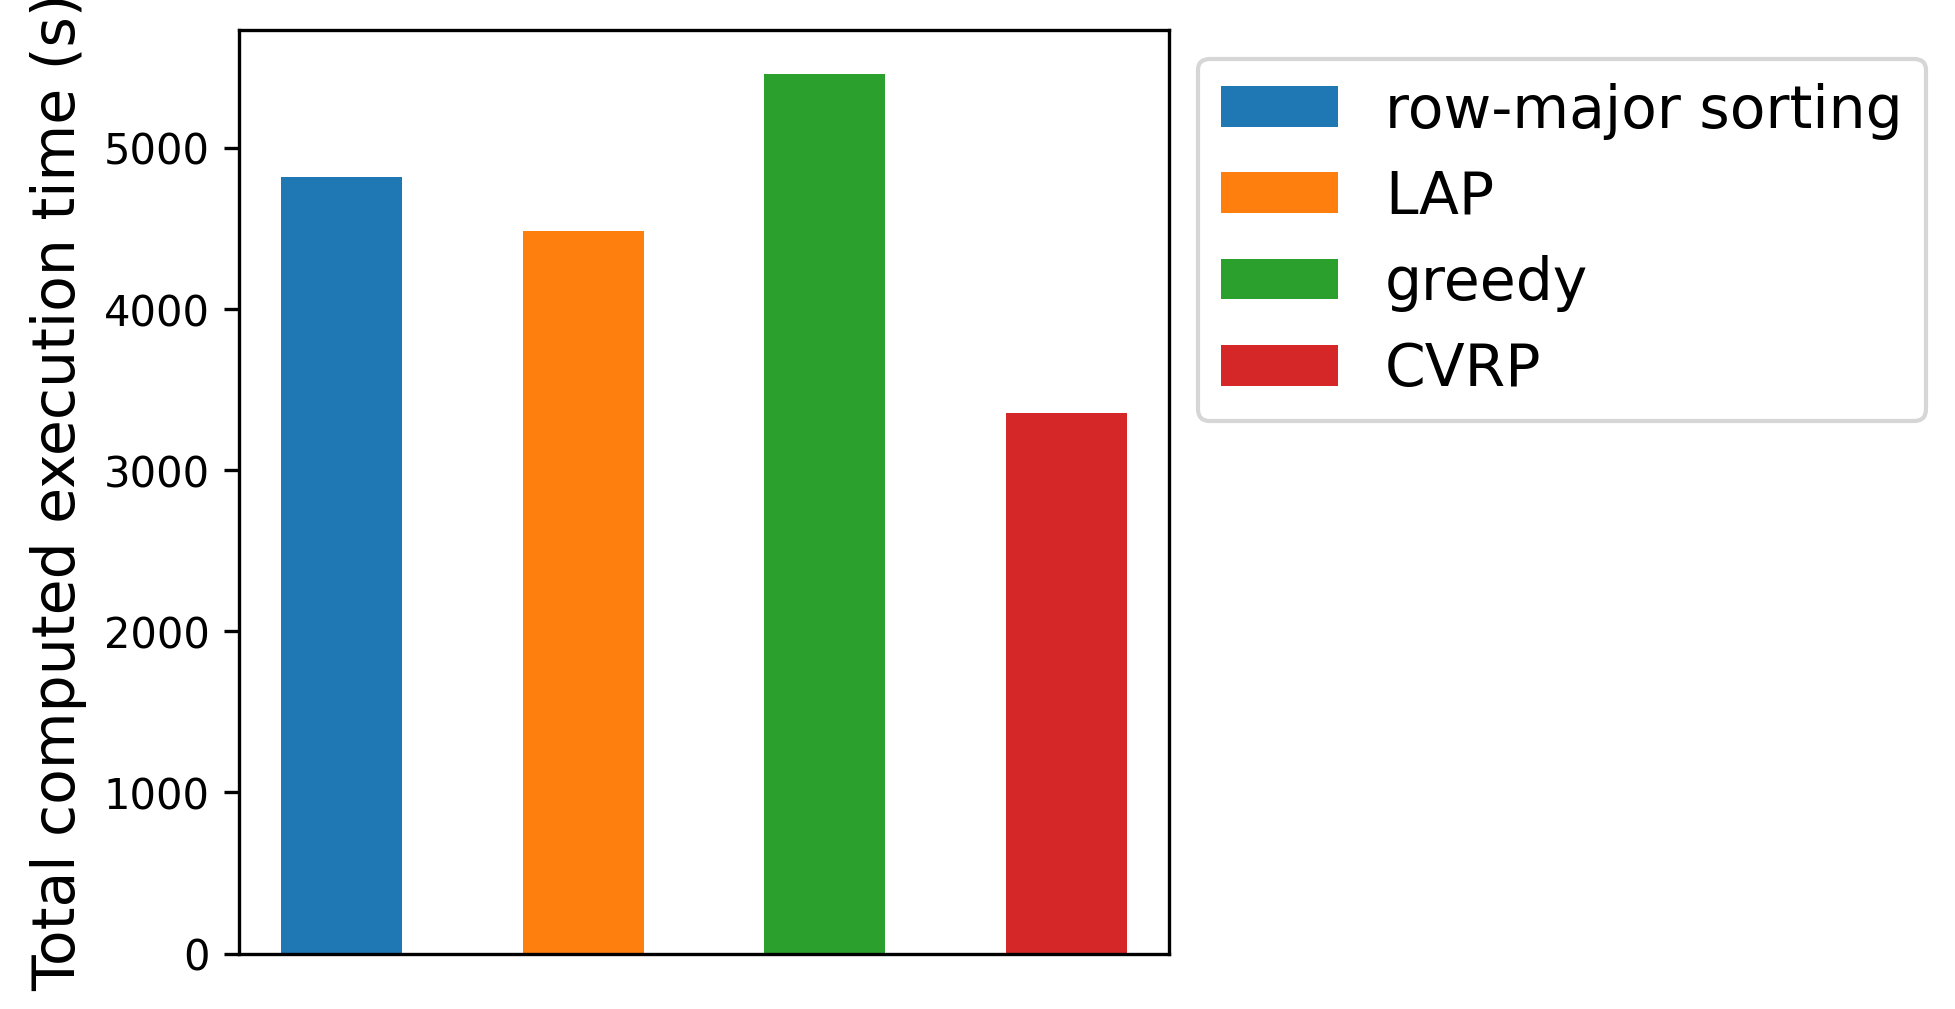

In [6]:
unoptimized_sum = df['row-major sorting'].sum()
rowwise_sum = df['LAP'].sum()
greedy_sum = df['greedy'].sum()
VRP_sum = df['CVRP'].sum()
fig, ax = plt.subplots(figsize=(4, 4),dpi=300)
# plot the data
names = ['row-major sorting', 'LAP', 'greedy', 'CVRP']
counts = [unoptimized_sum, rowwise_sum, greedy_sum, VRP_sum]
bar_labels = ['row-major sorting', 'LAP', 'greedy', 'CVRP']
bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
ax.bar(names, counts, label= bar_labels,color=bar_colors,width=0.5)
ax.set_ylabel('Total computed execution time (s)', fontsize=14)
# place the legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
# don't show the x-axis ticks
ax.set_xticks([])
plt.show()

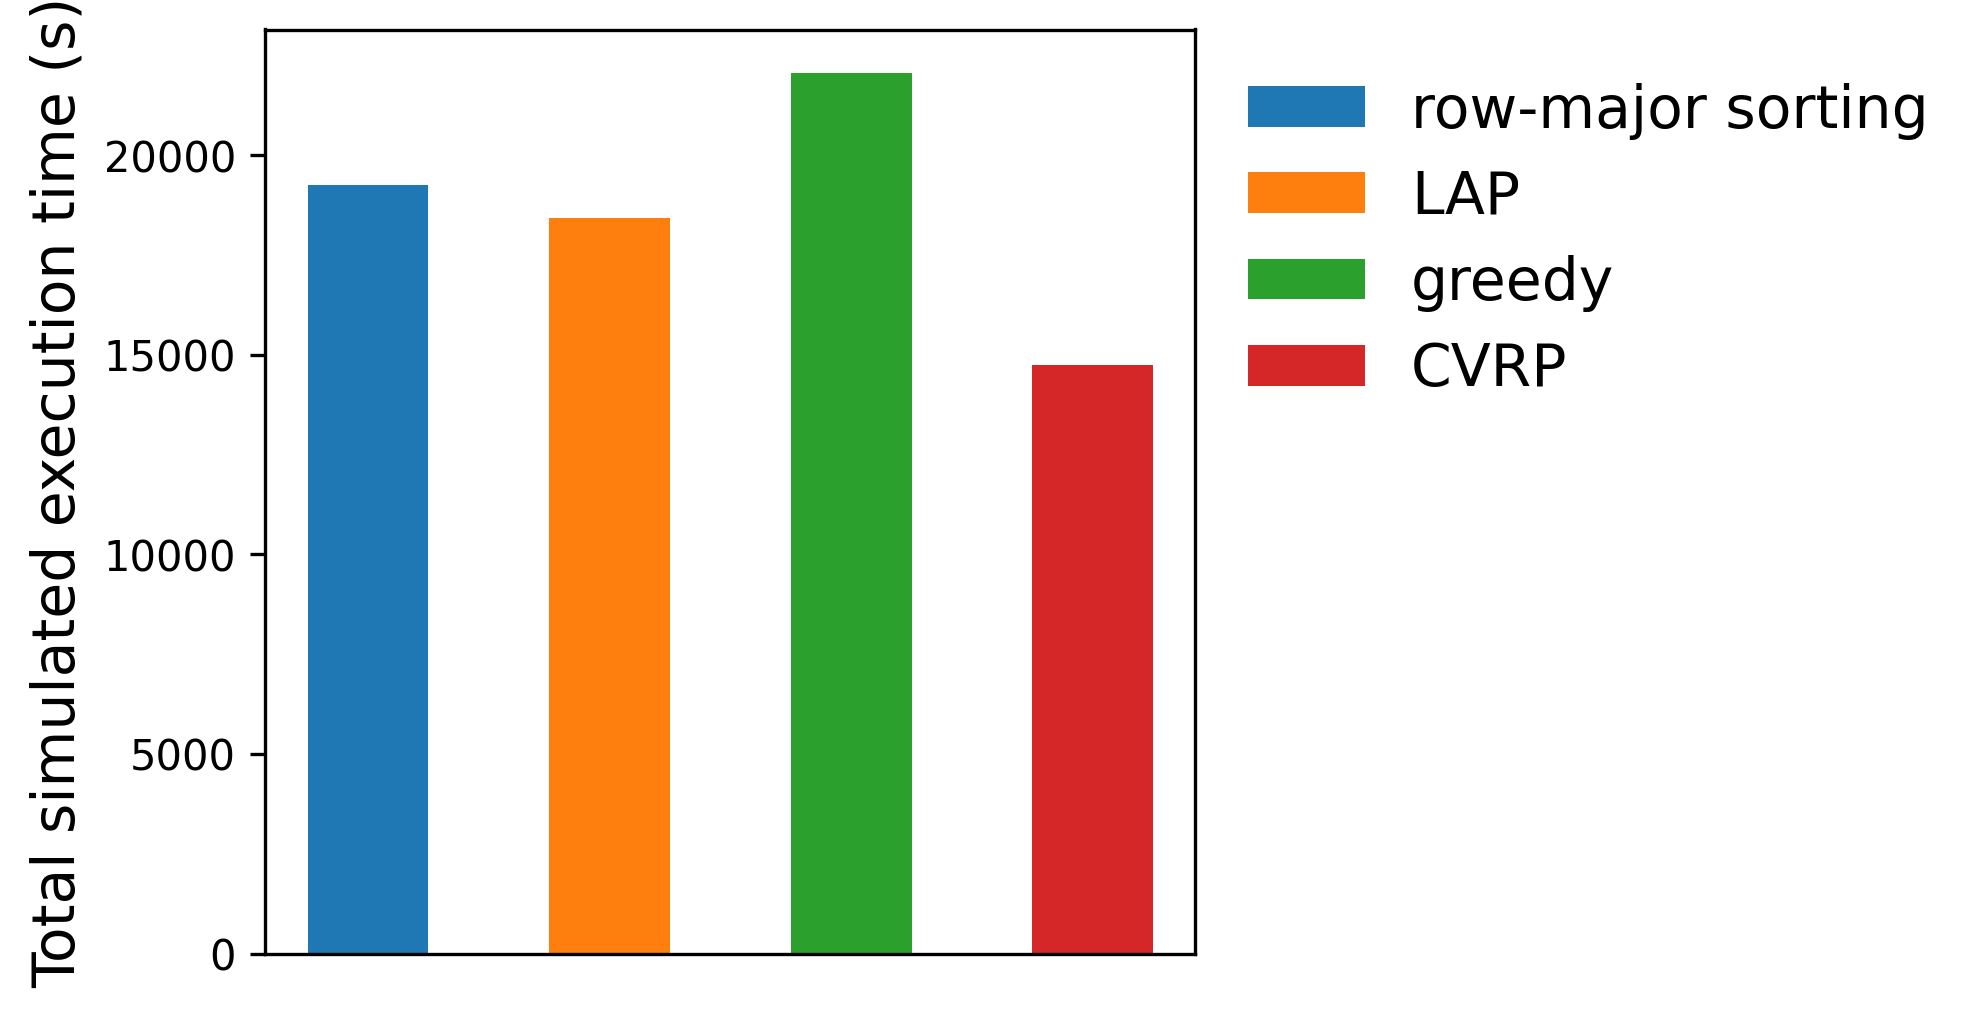

In [8]:
df = pd.read_csv('real_world_task/real_world_task_simulated_A100D100.csv')
unoptimized_sum = df['row-major sorting'].sum()
rowwise_sum = df['LAP'].sum()
greedy_sum = df['greedy'].sum()
VRP_sum = df['CVRP'].sum()
fig, ax = plt.subplots(figsize=(4, 4),dpi=300)
# plot the data
names = ['row-major sorting', 'LAP', 'greedy', 'CVRP']
counts = [unoptimized_sum, rowwise_sum, greedy_sum, VRP_sum]
bar_labels = ['row-major sorting', 'LAP', 'greedy', 'CVRP']
bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
ax.bar(names, counts, label= bar_labels,color=bar_colors,width=0.5)
ax.set_ylabel('Total simulated execution time (s)', fontsize=14)
# place the legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14,frameon=False)
# don't show the x-axis ticks
ax.set_xticks([])
plt.show()

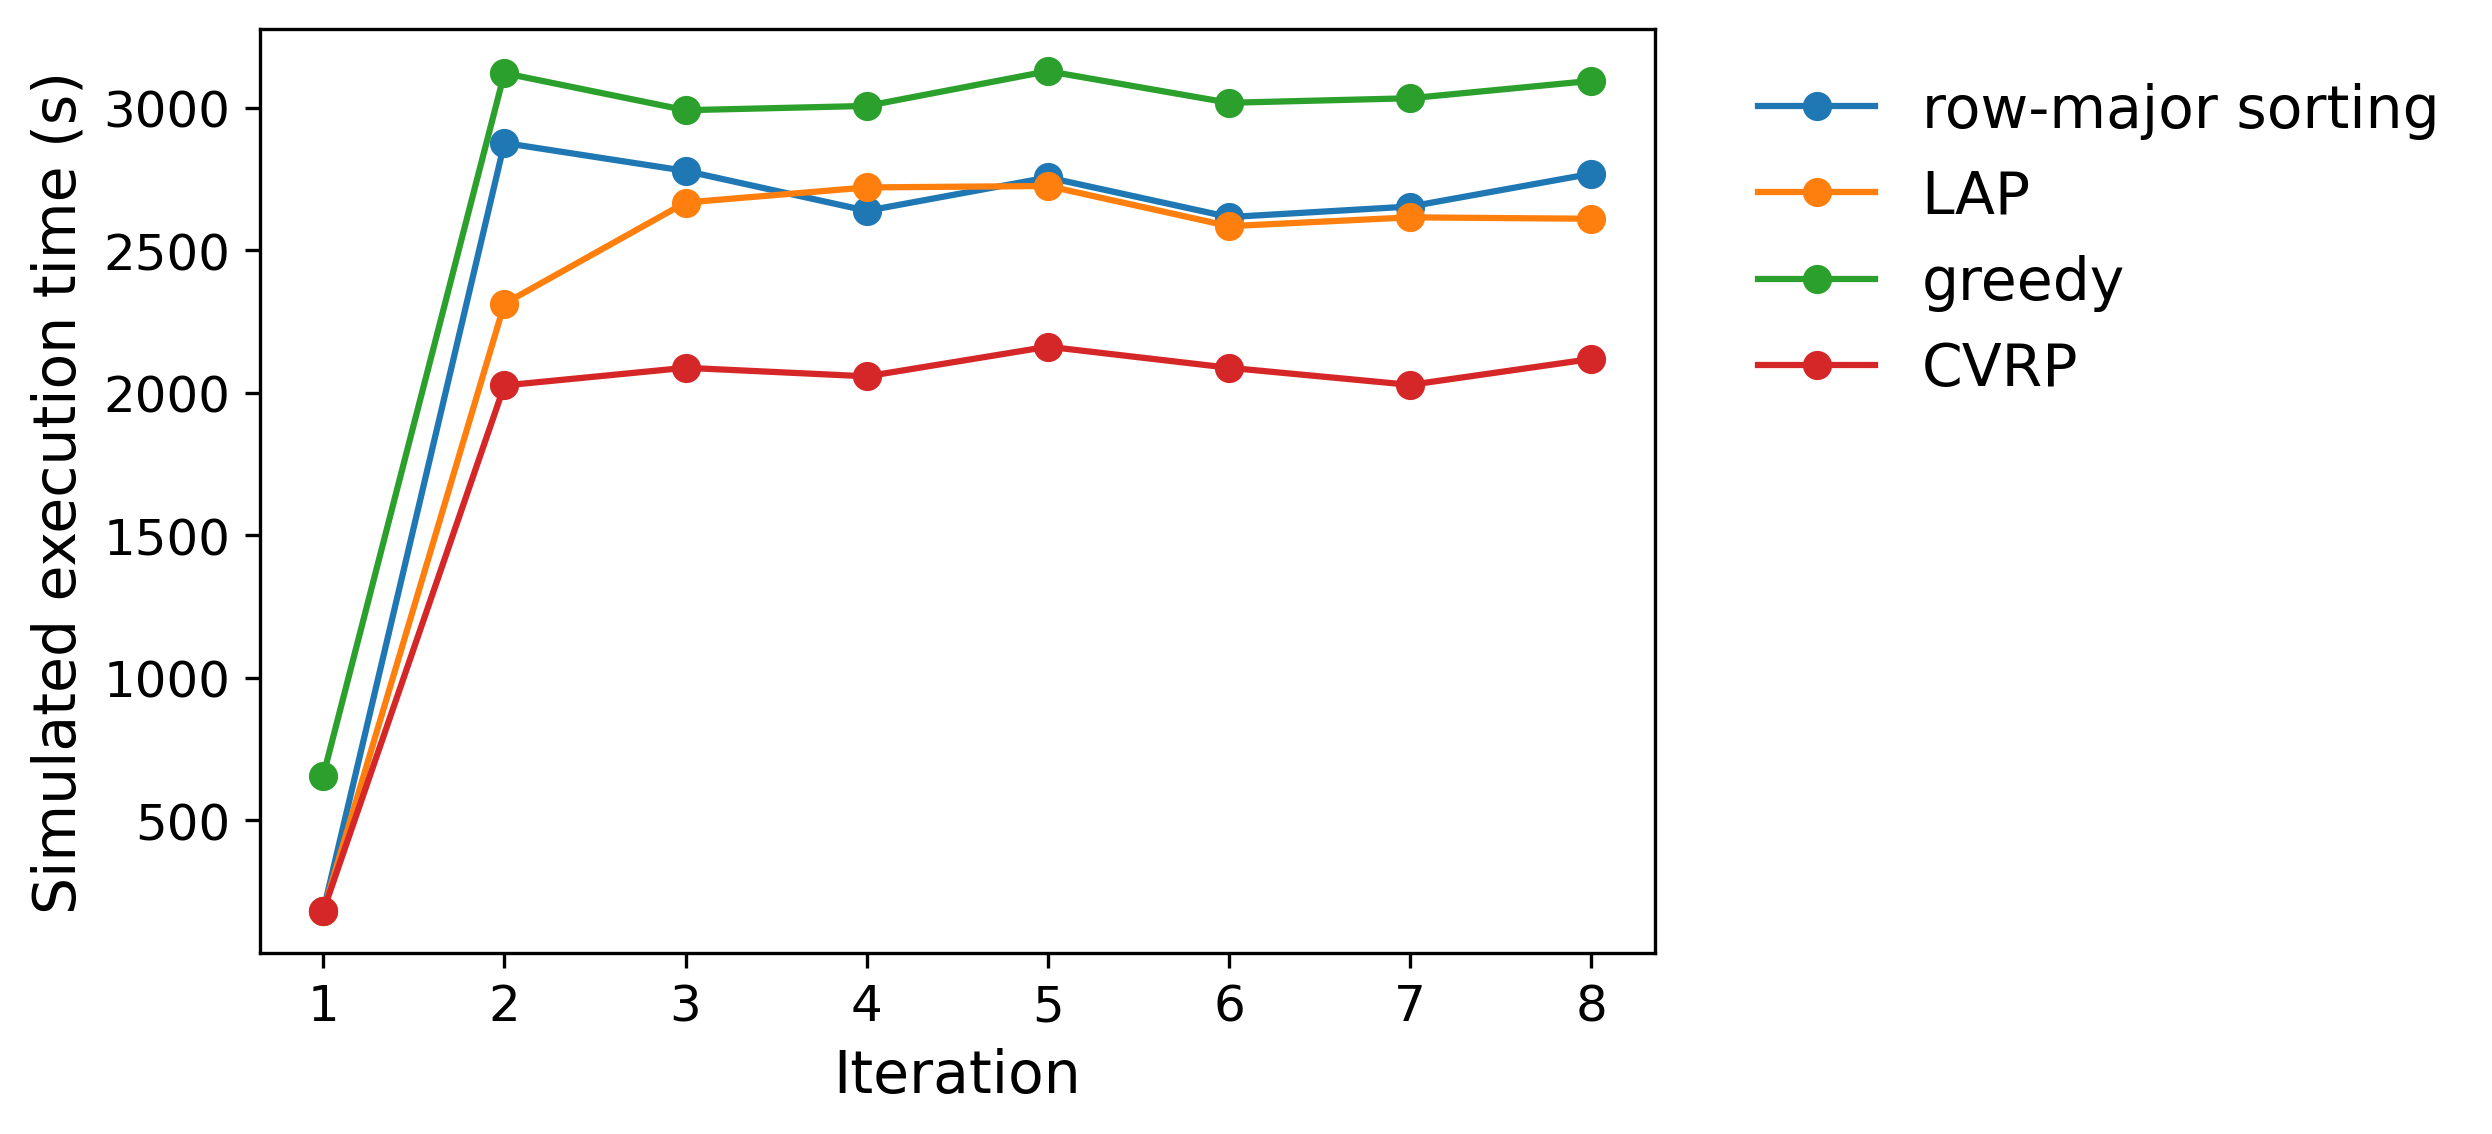

In [11]:
# plot the run time comparison of each interation of run_time_summary as dots connected by lines
run_time_summary = pd.read_csv('real_world_task/real_world_task_simulated_A100D100.csv')
plt.figure(figsize=(6, 4),dpi=300)
plt.plot(run_time_summary['iteration'], run_time_summary['row-major sorting'], marker='o', label='row-major sorting', color='#1f77b4')
plt.plot(run_time_summary['iteration'], run_time_summary['LAP'], marker='o', label='LAP', color='#ff7f0e')
plt.plot(run_time_summary['iteration'], run_time_summary['greedy'], marker='o', label='greedy', color='#2ca02c')
plt.plot(run_time_summary['iteration'], run_time_summary['CVRP'], marker='o', label='CVRP', color='#d62728')
#plt.title('Execution time over iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Simulated execution time (s)', fontsize=14)
# move the legend to the upper right outside the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1), fontsize=14., frameon=False)